# Annual reports

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [101]:
daily_return = pd.read_csv("../database/mergedData/Annual_Daily_Return.csv", index_col=[0])
report_value = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])

### Cast to quasi logarithmic differential model

In [103]:
# Function cast report in value -> diff in quasi log scale
def castToDiffQuasiLog(report_value : pd.DataFrame) -> pd.DataFrame: 
    QUASI_LOG_VALUE = 1e-6
    new_index = report_value.index.to_numpy()[1:] # Without first row
    reports_np =  report_value.to_numpy()
    log_value = np.vectorize(lambda x : np.log10(np.max([x, QUASI_LOG_VALUE])))(reports_np[:,2:])
    log_diff = log_value[1:] - log_value[:-1]
    reports_np = reports_np[1:]
    reports_np[:, 2:] = log_diff
    return pd.DataFrame(data=reports_np, 
                        columns=report_value.columns, 
                        index=new_index)


#Prepare data frame 
log_diff_database = pd.DataFrame(columns=report_value.columns)

# For all tickers 
tickers = report_value["Ticker"].unique()
for ticker in tickers:
    company_data = report_value[report_value["Ticker"] == ticker]
    company_log_diff = castToDiffQuasiLog(company_data)
    log_diff_database = pd.concat([log_diff_database, company_log_diff], ignore_index=False)

## Prepare data to learn

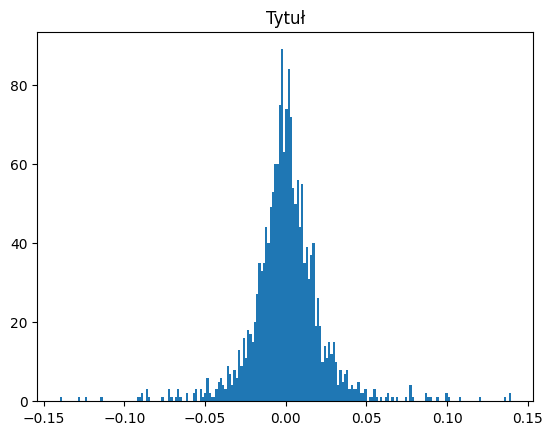

In [234]:
# Connect database to target 
database = pd.concat([log_diff_database, daily_return], axis=1, join="inner")
numeric_target = (database["Post7D"]-database["Pre7D"]).to_numpy()
up_bound = numeric_target.mean() + 3 * numeric_target.std()
down_bound = numeric_target.mean() - 3 * numeric_target.std()
numeric_target_3s = numeric_target[np.logical_and(numeric_target > down_bound, numeric_target < up_bound)]
counts, bins = np.histogram(numeric_target_3s, bins=200)
plt.stairs(counts, bins, fill=True)
plt.title("Tytuł")
plt.show()

In [254]:
# Arbitrary categorization 
y = pd.cut(np.array(numeric_target), bins=[-np.inf, -0.04, -0.01, -0.002, 0.002, 0.01, 0.04, np.inf], labels=[-3, -2, -1, 0, 1, 2, 3]).to_numpy()
x = database.to_numpy()[:,2:-6]

In [280]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1)

In [283]:
x_train_df = pd.DataFrame(X_train, columns=database.columns.to_numpy()[2:-6])
corr = x_train_df.corr()

,Przychody ze sprzedaży,Techniczny koszt wytworzenia produkcji sprzedanej,Koszty sprzedaży,Koszty ogólnego zarządu,Zysk ze sprzedaży,Pozostałe przychody operacyjne,Pozostałe koszty operacyjne,Zysk operacyjny (EBIT),Przychody finansowe,Koszty finansowe,...,Rozliczenia międzyokresowe,Pasywa razem,Przepływy pieniężne z działalności operacyjnej,Amortyzacja,Przepływy pieniężne z działalności inwestycyjnej,CAPEX (niematerialne i rzeczowe),Przepływy pieniężne z działalności finansowej,Emisja akcji,Dywidenda,Przepływy pieniężne razem
Przychody ze sprzedaży,1.000000,0.604934,0.262003,0.177755,0.134925,-0.008836,0.035098,0.151712,0.081065,0.059016,...,-0.044857,0.578916,0.068874,0.858181,-0.025731,0.267335,-0.013153,-0.060212,0.014590,0.004478
Techniczny koszt wytworzenia produkcji sprzedanej,0.604934,1.000000,0.100285,-0.150641,0.100933,-0.056560,-0.009448,0.124974,0.005934,0.028246,...,-0.049700,0.291116,0.058343,0.414237,-0.018363,0.091973,-0.012761,-0.096820,0.011349,0.015754
Koszty sprzedaży,0.262003,0.100285,1.000000,0.534503,0.020695,-0.018153,0.032851,0.031392,0.002982,0.051206,...,-0.067397,0.310014,0.068444,0.235365,-0.023018,0.070151,0.028532,0.016689,0.015708,0.059645
Koszty ogólnego zarządu,0.177755,-0.150641,0.534503,1.000000,-0.028375,0.073299,0.108445,-0.006908,-0.020942,0.109267,...,0.055015,0.117726,0.026461,0.206289,-0.043885,0.088501,-0.016054,-0.001344,0.033311,-0.013146
Zysk ze sprzedaży,0.134925,0.100933,0.020695,-0.028375,1.000000,-0.025884,-0.063870,0.713953,0.040110,-0.008654,...,-0.072775,0.145253,0.042180,0.004491,-0.043544,0.020655,-0.058795,0.024711,0.002915,0.021503
Pozostałe przychody operacyjne,-0.008836,-0.056560,-0.018153,0.073299,-0.025884,1.000000,0.117567,0.139829,0.055569,0.055762,...,0.012447,0.004140,0.044596,0.024072,-0.003572,0.016504,-0.067148,-0.054726,0.054101,0.013597
Pozostałe koszty operacyjne,0.035098,-0.009448,0.032851,0.108445,-0.063870,0.117567,1.000000,-0.118472,0.091381,0.068803,...,0.005259,-0.030656,-0.020482,0.054528,-0.017772,0.047258,0.017075,0.006650,0.005172,0.001713
Zysk operacyjny (EBIT),0.151712,0.124974,0.031392,-0.006908,0.713953,0.139829,-0.118472,1.000000,0.032198,-0.028606,...,-0.047189,0.152834,0.031763,0.022013,-0.035477,0.013736,-0.059727,0.013067,0.011722,0.060141
Przychody finansowe,0.081065,0.005934,0.002982,-0.020942,0.040110,0.055569,0.091381,0.032198,1.000000,0.012298,...,-0.000118,0.113939,-0.017026,0.077989,0.019039,0.056502,-0.065425,0.007301,0.040488,-0.022573
Koszty finansowe,0.059016,0.028246,0.051206,0.109267,-0.008654,0.055762,0.068803,-0.028606,0.012298,1.000000,...,-0.095649,0.009600,-0.015634,0.112783,-0.048080,-0.042171,-0.006017,0.037816,0.020355,-0.056388
